# Objetivo
Sugerir novos clientes para um portfólio de entrada

# Metodologia

Com uma base de mais de 460.000 clientes o sistema de recomendação nesse notebook gera recomendações de possíveis leads para um portfólio de clientes fornecido como entrada.

As etapas de implementação do sistema contemplam a leitura da base com a biblioteca pandas, o preenchimento de valores nulos de acordo com sua categoria, na sequência codifica atráves do método de LabelEncoder as componentes para possibilitar a utilizaçaõ do algoritmo NearestNeihghbors, o qual possibilita o cálculo da distância entre o cliente de entrada e os clientes mais próximos.

Foi criada algumas funções auxiliares para a solução deste projeto

## Importando as bibliotecas

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd

from pandas_profiling import ProfileReport
import sweetviz as sv

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

#### Configurando setup de visualização

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

## Leitura dos arquivos que compõe o dataset

### Base com informações sobre as empresas do Mercado a ser considerado.

In [3]:
market = pd.read_csv('./base de dados/estaticos_market.csv', sep=',', index_col=0)

### Portfólio empresa 1

In [4]:
port_1 = pd.read_csv('./base de dados/estaticos_portfolio1.csv', usecols=['id']).merge(market, on='id', how='inner')

### Portfólio empresa 2

In [5]:
port_2 = pd.read_csv('./base de dados/estaticos_portfolio2.csv', usecols=['id']).merge(market, on='id', how='inner')

### Portfólio empresa 3

In [6]:
port_3 = pd.read_csv('./base de dados/estaticos_portfolio3.csv', usecols=['id']).merge(market, on='id', how='inner')

### Criando relatório de EDA com Pandas profiling

In [7]:
# profile = ProfileReport(market, minimal=True)
# profile.to_file("pp-market-eda.html")

### Funções criadas para auxiliar a resolução do problema

In [8]:
def exploracao(df):
    """
    Gera uma dataframe com informações relevantes sobre o mesmo.
    
    :param df: pd.DataFrame para ser realizada a exploração
    """
    
    exploracao = pd.DataFrame({
        'coluna' : df.columns,
        'tipos' : df.dtypes,
        'qtd_null' : df.isnull().sum()
    })
    
    exploracao['percent_null'] = np.round((exploracao.qtd_null / df.shape[0]) * 100, 4)
    
    return exploracao.sort_values(by='qtd_null', ascending=False)

In [9]:
def remover_colunas():
    
    # Razões para excluir, analises de acordo com os relatórios gerados com Pandas Profiling e Sweetviz
    
    # Alta cardinalidade
    # 'de_natureza_juridica', 'dt_situacao', 'nm_divisao', 'nm_micro_regiao'
    
    # Como aparenta ser uma coluna atualizada mês a mês, existe uma probabilidade de estar desatualizada
    # 'nu_meses_rescencia', 'de_saude_rescencia'
    
    # Existe coluna com esses dados de forma numerica, por esse motivo também vamos excluir estas
    # 'de_faixa_faturamento_estimado_grupo', 'de_faixa_faturamento_estimado', 'idade_emp_cat', 'fl_veiculo'
    
    # Colunas sem relevancia
    # 'fl_email', 'fl_telefone'
    
    # A matriz da empresa acredito que não vá ter relevância, então mantendo apenas a filial
    # sg_uf_matriz
    
    # Coluna com apenas valores false
    # fl_epp
    
    
    colunas = ['de_natureza_juridica', 'dt_situacao', 'nm_divisao', 'nm_micro_regiao', 'nu_meses_rescencia',
               'de_saude_rescencia', 'de_faixa_faturamento_estimado_grupo', 'de_faixa_faturamento_estimado',
               'idade_emp_cat', 'fl_veiculo', 'fl_email', 'fl_telefone', 'sg_uf_matriz', 'fl_epp' ]
    
    return colunas

In [10]:
def filter_columns(df):
    """
    Retorna um pd.DataFrame com as features que tem 80% de valores não nulos.
    
    :param df: pd.DataFrame para ser realizada a filtragem das features
    """
    
    df_exploracao = exploracao(df)
    features = df_exploracao[(df_exploracao.percent_null < 20.0)]['coluna']
    df = df[features]
    
    df = df[df.columns.difference(remover_colunas())]

    return df

In [11]:
def encoding_obj(df, le):
    """
    Retorna pd.DataFrame com as colunas 'object' e 'booleanas' realizado o encoding
    
    :param df: pd.DataFrame que vai ter as colunas realizado o encoding
    :param le: instancia da classe LabelEnconde() no qual fará o encoding
    """
    
    colunas_obj = df.columns[df.dtypes == object]
    df[colunas_obj] = df[colunas_obj].apply(lambda col: le.fit_transform(col) if col.name != 'id' else col)
    
    colunas_bool = df.columns[df.dtypes == bool]
    df[colunas_bool] = df[colunas_bool].apply(lambda col: le.fit_transform(col))

    return df

In [12]:
def treino_teste_port(df):
    """
    Retorna dois dataframes, treino e teste que foi divido
    
    :param df: pd.Dataframe o dataframe que será divido em treino e teste
    """
    
    X_train, X_test, y_train, y_test = train_test_split(
    df, list(range(len(df))), test_size=0.3, random_state=1)
    
    return X_train, X_test

In [13]:
def lista_simples(lista):
    """
    Transforma a lista de listas em uma lista simples
    
    :param lista: lista de listas 
    """
    if isinstance(lista, list):
        return [sub_elem for elem in lista for sub_elem in lista_simples(elem)]
    else:
        return [lista]

In [14]:
def probabilidade(x, divisor):
    """
    Calcula a probabilidade de acerto da recomendação gerada pelo modelo
    
    :param x: int quantidade de acertos
    :divisor: int quantidade de linhas do dataframe de teste
    """
    
    resultado = np.round((x * 100) / divisor, 2)
    
    print(f'A probabilidade de acerto foi de: {resultado}%')

In [15]:
def fillna_columns(df):
    """
    Tratar os valores nulos do daframe
    
    Esta função foi baseada na função do github: pvoloshyn
    
    :param df: pd.Dataframe dataframe que será tratado os valores nulos
    """
    
    for col in df.columns:
        
        if 'fl_' in col:
            if {'SIM', 'NAO'} <= set(df[col]):
                df[col] = (df[col] == 'SIM')
            df[col] = df[col].fillna(False)  
            
        elif df[col].dtype == 'object':
            df[col] = df[col].fillna('SEM INFORMACAO' if 'de_' in col else 'OUTRA')
            
        elif df[col].dtype == 'float':
            mean = df[col].mean()
            df[col] = df[col].fillna(mean)

        else:
             pass
            
    return df

In [16]:
def knn(X_train, modelo):
    """
    Retorna duas listas, indices_knn e distancias_knn. Com informações dos vizinhos recomendados pelo modelo
    
    :param X_train: pd.Dataframe de treino para realizar a validação
    :param modelo: NearestNeighbors modelo treinado
    """
    
    indices_knn =  []
    distancias_knn = []
    for i in range(X_train.shape[0]):
        distancias, indices = modelo.kneighbors([X_train.loc[X_train.index[i]]], n_neighbors=5)
        indices_knn.append(list(indices[0]))
        distancias_knn.append(list(distancias[0]))
        
    return indices_knn, distancias_knn

In [17]:
def criar_df_recomendacao(lista_indices_knn, lista_distancias_knn, market):
    """
    Retorna um pd.Dataframe com os leads
    
    :param lista_indices_knn: lista de indices mais proximos
    :param lista_distancias_knn: lista das distancias de cada indice
    :param market: pd.Dataframe dataframe base
    """
    
    results = list(zip(lista_indices_knn, lista_distancias_knn))
    df_results = pd.DataFrame(results, columns=['indices', 'distancias'])
    
    top = df_results.groupby('indices').agg(count=('indices', 'count'), distances=('distancias', 'min'))\
                                    .sort_values(['count', 'distances'], ascending=[False, True]).index.values

    
    df_knn = market.loc[top].set_index('id')
    df_knn = df_knn[~df_knn.index.isin(X_train.index)]
    
    return df_knn

## Conhecendo mais sobre os dados

In [18]:
exploracao(market)

,coluna,tipos,qtd_null,percent_null
qt_alteracao_socio_total,qt_alteracao_socio_total,float64,462298,100.0000
qt_alteracao_socio_90d,qt_alteracao_socio_90d,float64,462298,100.0000
grau_instrucao_macro_desconhecido,grau_instrucao_macro_desconhecido,float64,462298,100.0000
qt_alteracao_socio_180d,qt_alteracao_socio_180d,float64,462298,100.0000
qt_alteracao_socio_365d,qt_alteracao_socio_365d,float64,462298,100.0000
coligada_mais_antiga_baixada,coligada_mais_antiga_baixada,float64,462162,99.9706
coligada_mais_nova_baixada,coligada_mais_nova_baixada,float64,462162,99.9706
idade_media_coligadas_baixadas,idade_media_coligadas_baixadas,float64,462162,99.9706
vl_total_veiculos_antt,vl_total_veiculos_antt,float64,462122,99.9619
vl_total_tancagem,vl_total_tancagem,float64,462018,99.9394


In [19]:
exploracao(port_1)

,coluna,tipos,qtd_null,percent_null
vl_total_veiculos_antt_grupo,vl_total_veiculos_antt_grupo,float64,555,100.0000
idade_media_coligadas_baixadas,idade_media_coligadas_baixadas,float64,555,100.0000
vl_total_tancagem_grupo,vl_total_tancagem_grupo,float64,555,100.0000
coligada_mais_antiga_baixada,coligada_mais_antiga_baixada,float64,555,100.0000
coligada_mais_nova_baixada,coligada_mais_nova_baixada,float64,555,100.0000
qt_alteracao_socio_total,qt_alteracao_socio_total,float64,555,100.0000
qt_alteracao_socio_90d,qt_alteracao_socio_90d,float64,555,100.0000
vl_total_veiculos_antt,vl_total_veiculos_antt,float64,555,100.0000
vl_total_tancagem,vl_total_tancagem,float64,555,100.0000
qt_alteracao_socio_180d,qt_alteracao_socio_180d,float64,555,100.0000


In [20]:
exploracao(port_2)

,coluna,tipos,qtd_null,percent_null
qt_alteracao_socio_180d,qt_alteracao_socio_180d,float64,566,100.0000
qt_alteracao_socio_total,qt_alteracao_socio_total,float64,566,100.0000
qt_alteracao_socio_365d,qt_alteracao_socio_365d,float64,566,100.0000
grau_instrucao_macro_desconhecido,grau_instrucao_macro_desconhecido,float64,566,100.0000
qt_alteracao_socio_90d,qt_alteracao_socio_90d,float64,566,100.0000
coligada_mais_nova_baixada,coligada_mais_nova_baixada,float64,565,99.8233
coligada_mais_antiga_baixada,coligada_mais_antiga_baixada,float64,565,99.8233
idade_media_coligadas_baixadas,idade_media_coligadas_baixadas,float64,565,99.8233
qt_socios_st_suspensa,qt_socios_st_suspensa,float64,565,99.8233
vl_total_veiculos_antt_grupo,vl_total_veiculos_antt_grupo,float64,561,99.1166


In [21]:
exploracao(port_3)

,coluna,tipos,qtd_null,percent_null
vl_total_veiculos_antt_grupo,vl_total_veiculos_antt_grupo,float64,265,100.0000
qt_alteracao_socio_90d,qt_alteracao_socio_90d,float64,265,100.0000
qt_alteracao_socio_365d,qt_alteracao_socio_365d,float64,265,100.0000
vl_total_veiculos_antt,vl_total_veiculos_antt,float64,265,100.0000
qt_alteracao_socio_180d,qt_alteracao_socio_180d,float64,265,100.0000
qt_socios_st_suspensa,qt_socios_st_suspensa,float64,265,100.0000
qt_alteracao_socio_total,qt_alteracao_socio_total,float64,265,100.0000
grau_instrucao_macro_desconhecido,grau_instrucao_macro_desconhecido,float64,265,100.0000
coligada_mais_nova_baixada,coligada_mais_nova_baixada,float64,264,99.6226
coligada_mais_antiga_baixada,coligada_mais_antiga_baixada,float64,264,99.6226


### Selecionando colunas relevantes

In [22]:
market = filter_columns(market)

### Preenchendo valores nulos

In [23]:
market = fillna_columns(market)

In [24]:
exploracao(market)

,coluna,tipos,qtd_null,percent_null
de_nivel_atividade,de_nivel_atividade,object,0,0.0
de_ramo,de_ramo,object,0,0.0
vl_total_veiculos_leves_grupo,vl_total_veiculos_leves_grupo,float64,0,0.0
vl_faturamento_estimado_grupo_aux,vl_faturamento_estimado_grupo_aux,float64,0,0.0
vl_faturamento_estimado_aux,vl_faturamento_estimado_aux,float64,0,0.0
sg_uf,sg_uf,object,0,0.0
setor,setor,object,0,0.0
qt_filiais,qt_filiais,int64,0,0.0
nm_segmento,nm_segmento,object,0,0.0
nm_meso_regiao,nm_meso_regiao,object,0,0.0


### Realizar encoding das features categóricas

In [25]:
le = LabelEncoder()
market_graph = market.copy()
market = encoding_obj(market, le)
market.head()

,de_nivel_atividade,de_ramo,de_saude_tributaria,fl_antt,fl_ltda,fl_matriz,fl_me,fl_mei,fl_optante_simei,fl_optante_simples,fl_passivel_iss,fl_rm,fl_sa,fl_simples_irregular,fl_spa,fl_st_especial,id,idade_empresa_anos,natureza_juridica_macro,nm_meso_regiao,nm_segmento,qt_filiais,setor,sg_uf,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,vl_total_veiculos_leves_grupo,vl_total_veiculos_pesados_grupo
0,0,11,5,0,0,1,0,0,0,1,1,1,0,0,0,0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,14.457534,2,6,10,0,2,4,3132172.8,3132172.8,0.0,0.0
1,1,21,2,0,0,1,0,1,0,0,1,1,0,0,0,0,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,1.463014,5,4,3,0,5,3,210000.0,210000.0,0.0,0.0
2,2,32,0,0,0,1,0,1,1,1,1,1,0,0,0,0,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,7.093151,5,2,21,0,5,1,50000.0,50000.0,0.0,0.0
3,2,25,0,0,0,1,0,0,0,1,1,1,0,0,0,0,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,6.512329,5,2,18,0,5,1,210000.0,210000.0,0.0,0.0
4,0,27,5,0,0,1,0,0,0,1,1,1,0,0,0,0,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,3.200000,5,6,8,0,5,4,210000.0,210000.0,0.0,0.0


## Criando relatório de EDA com a lib Sweet Viz

In [26]:
# my_report = sv.analyze(market)
# my_report.show_html(filepath='eda-enconding.html')

### Criando instância do NearestNeighbors

In [27]:
modelo = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='minkowski', n_jobs=-1)

### Treinando modelo

In [28]:
%%time
modelo.fit(market.set_index('id'))

CPU times: user 5min 40s, sys: 888 ms, total: 5min 41s
Wall time: 5min 39s


NearestNeighbors(algorithm='ball_tree', n_jobs=-1)

### Resultados para o portfólio 1

In [29]:
pf1 = pd.merge(port_1[['id']], market, on='id', how='inner')

### Dividindo o portfólio em treino e teste

In [30]:
X_train, X_test = treino_teste_port(pf1.set_index('id'))

print(f"Treino tem o shape {X_train.shape}")
print(f"Teste tem o shape {X_test.shape}")

Treino tem o shape (388, 27)
Teste tem o shape (167, 27)


In [31]:
%%time
indices_knn, distancias_knn = knn(X_train, modelo)

CPU times: user 4.98 s, sys: 873 ms, total: 5.86 s
Wall time: 41.4 s


In [32]:
lista_indices_knn = lista_simples(indices_knn)
lista_distancias_knn = lista_simples(distancias_knn)

In [33]:
df_recsys = criar_df_recomendacao(lista_indices_knn, lista_distancias_knn, market)
df_recsys.shape

(1545, 27)

In [34]:
acertou = X_test.index.isin(df_recsys.index).sum()
acertou

1

In [35]:
probabilidade(acertou, X_test.shape[0])

A probabilidade de acerto foi de: 0.6%


# Para o porfólio 1
- a probabilidade de acerto foi de 0.6%
- foram recomendadas 1.545 empresas
- 167 empresas dos dados de teste, o modelo acertou 1

## Gráficos comparativos

In [71]:
df1_graph = df_recsys.reset_index()

In [72]:
leads_1 = market_graph[market_graph.id.isin(df1_graph.id)]

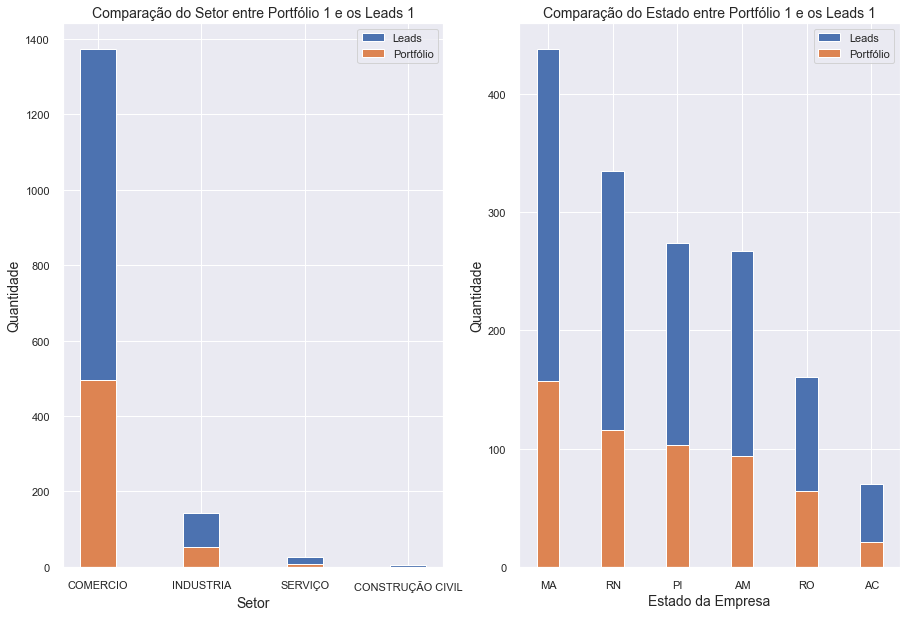

In [106]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(nrows=1, ncols=2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(\
     x=leads_1.setor.value_counts().index,
     height=leads_1.setor.value_counts().values,
     width = 0.35,
     label='Leads')

ax1.bar(\
     x=port_1.setor.value_counts().index,
     height=port_1.setor.value_counts().values,
     width = 0.35, label='Portfólio')

ax1.legend()
plt.xlabel('Setor', fontsize=14)
plt.ylabel('Quantidade', fontsize=14)
plt.title('Comparação do Setor entre Portfólio 1 e os Leads 1', fontsize=14)
######
######
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(\
     x=leads_1.sg_uf.value_counts().index,
     height=leads_1.sg_uf.value_counts().values,
     width = 0.35,
     label='Leads')

ax2.bar(\
     x=port_1.sg_uf.value_counts().index,
     height=port_1.sg_uf.value_counts().values,
     width = 0.35, label='Portfólio')

ax2.legend()
plt.xlabel('Estado da Empresa', fontsize=14)
plt.ylabel('Quantidade', fontsize=14 )
plt.title('Comparação do Estado entre Portfólio 1 e os Leads 1', fontsize=14)

plt.show()

# Resultados para o portfólio 2

In [74]:
pf2 = pd.merge(port_2[['id']], market, on='id', how='inner')

### Dividindo o portfólio em treino e teste

In [75]:
X_train, X_test = treino_teste_port(pf2.set_index('id'))

print(f"Treino tem o shape {X_train.shape}")
print(f"Teste tem o shape {X_test.shape}")

Treino tem o shape (396, 27)
Teste tem o shape (170, 27)


In [76]:
%%time
indices_knn, distancias_knn = knn(X_train, modelo)

CPU times: user 2.82 s, sys: 931 ms, total: 3.76 s
Wall time: 41.8 s


In [77]:
lista_indices_knn = lista_simples(indices_knn)
lista_distancias_knn = lista_simples(distancias_knn)

In [78]:
df_recsys = criar_df_recomendacao(lista_indices_knn, lista_distancias_knn, market)
df_recsys.shape

(911, 27)

In [79]:
acertou = X_test.index.isin(df_recsys.index).sum()
acertou

102

In [80]:
probabilidade(acertou, X_test.shape[0])

A probabilidade de acerto foi de: 60.0%


# Para o porfólio 2
- a probabilidade de acerto foi de 60%
- foram recomendadas 911 empresas
- 170 empresas dos dados de teste, o modelo acertou 102

## Gráficos comparativos

In [81]:
df2_graph = df_recsys.reset_index()

In [82]:
leads_2 = market_graph[market_graph.id.isin(df2_graph.id)]

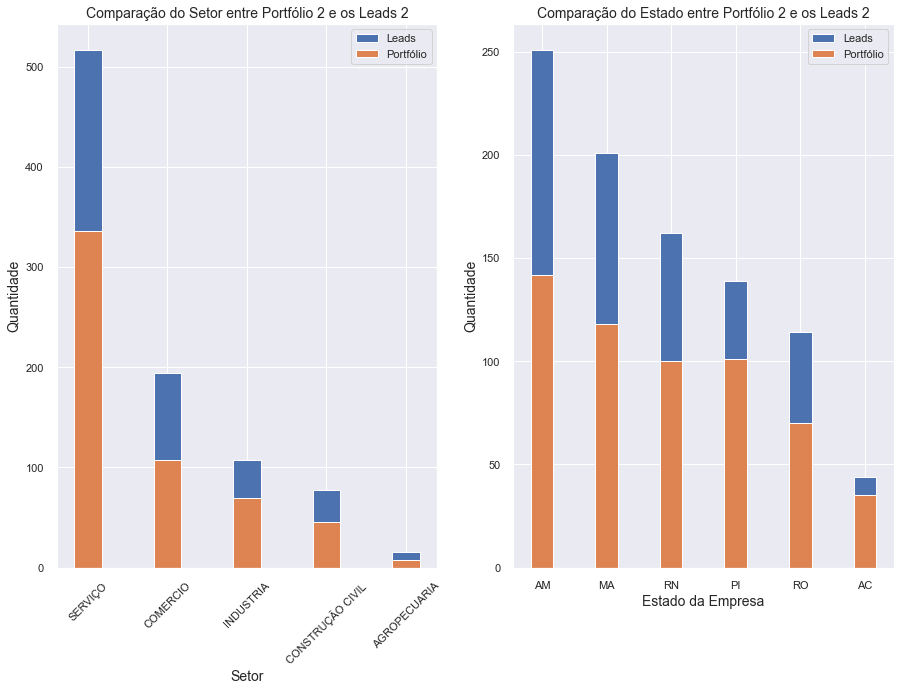

In [105]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(nrows=1, ncols=2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(\
     x=leads_2.setor.value_counts().index,
     height=leads_2.setor.value_counts().values,
     width = 0.35,
     label='Leads')

ax1.bar(\
     x=port_2.setor.value_counts().index,
     height=port_2.setor.value_counts().values,
     width = 0.35, label='Portfólio')

ax1.legend()
plt.xticks(rotation=45)
plt.xlabel('Setor', fontsize=14)
plt.ylabel('Quantidade', fontsize=14)
plt.title('Comparação do Setor entre Portfólio 2 e os Leads 2', fontsize=14)
######
######
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(\
     x=leads_2.sg_uf.value_counts().index,
     height=leads_2.sg_uf.value_counts().values,
     width = 0.35,
     label='Leads')

ax2.bar(\
     x=port_2.sg_uf.value_counts().index,
     height=port_2.sg_uf.value_counts().values,
     width = 0.35, label='Portfólio')

ax2.legend()
plt.xlabel('Estado da Empresa', fontsize=14)
plt.ylabel('Quantidade', fontsize=14 )
plt.title('Comparação do Estado entre Portfólio 2 e os Leads 2', fontsize=14)

plt.show()

# Resultados para o portfólio 3

In [88]:
pf3 = pd.merge(port_3[['id']], market, on='id', how='inner')

### Dividindo o portfólio em treino e teste

In [89]:
X_train, X_test = treino_teste_port(pf3.set_index('id'))

print(f"Treino tem o shape {X_train.shape}")
print(f"Teste tem o shape {X_test.shape}")

Treino tem o shape (185, 27)
Teste tem o shape (80, 27)


In [90]:
%%time
indices_knn, distancias_knn = knn(X_train, modelo)

CPU times: user 1.52 s, sys: 437 ms, total: 1.95 s
Wall time: 19.7 s


In [91]:
lista_indices_knn = lista_simples(indices_knn)
lista_distancias_knn = lista_simples(distancias_knn)

In [92]:
df_recsys = criar_df_recomendacao(lista_indices_knn, lista_distancias_knn, market)
df_recsys.shape

(438, 27)

In [93]:
acertou = X_test.index.isin(df_recsys.index).sum()
acertou

34

In [94]:
probabilidade(acertou, X_test.shape[0])

A probabilidade de acerto foi de: 42.5%


# Para o porfólio 3
- a probabilidade de acerto foi de 42.50%
- foram recomendadas 438 empresas
- 80 empresas dos dados de teste, o modelo acertou 34

## Gráficos comparativos

In [98]:
df3_graph = df_recsys.reset_index()

In [99]:
leads_3 = market_graph[market_graph.id.isin(df3_graph.id)]

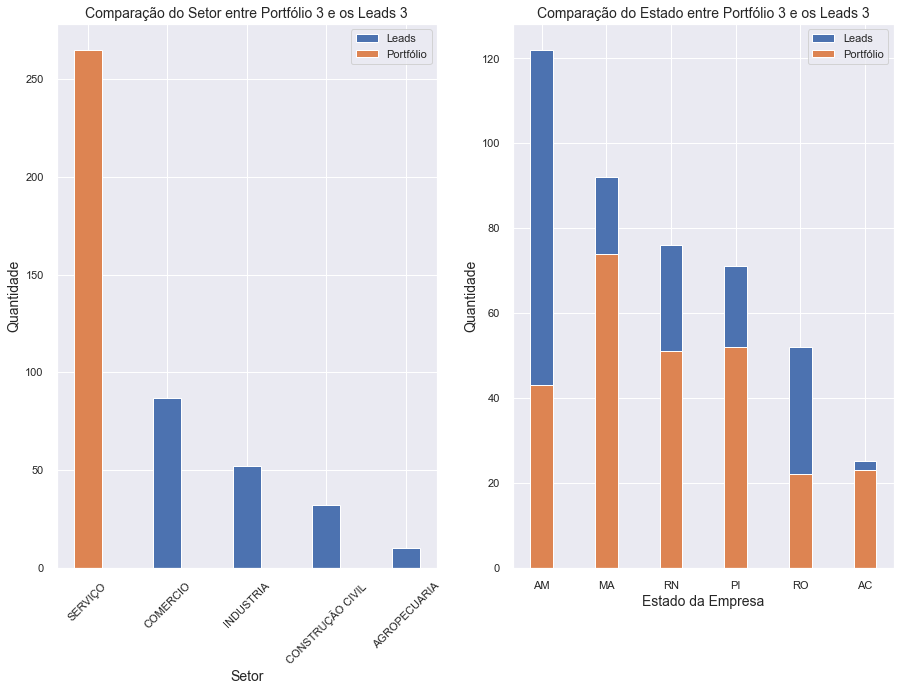

In [107]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(nrows=1, ncols=2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(\
     x=leads_3.setor.value_counts().index,
     height=leads_3.setor.value_counts().values,
     width = 0.35,
     label='Leads')

ax1.bar(\
     x=port_3.setor.value_counts().index,
     height=port_3.setor.value_counts().values,
     width = 0.35, label='Portfólio')

ax1.legend()
plt.xticks(rotation=45)
plt.xlabel('Setor', fontsize=14)
plt.ylabel('Quantidade', fontsize=14)
plt.title('Comparação do Setor entre Portfólio 3 e os Leads 3', fontsize=14)
######
######
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(\
     x=leads_3.sg_uf.value_counts().index,
     height=leads_3.sg_uf.value_counts().values,
     width = 0.35,
     label='Leads')

ax2.bar(\
     x=port_3.sg_uf.value_counts().index,
     height=port_3.sg_uf.value_counts().values,
     width = 0.35, label='Portfólio')

ax2.legend()
plt.xlabel('Estado da Empresa', fontsize=14)
plt.ylabel('Quantidade', fontsize=14 )
plt.title('Comparação do Estado entre Portfólio 3 e os Leads 3', fontsize=14)

plt.show()